In [150]:
!pip install rdkit-pypi
!pip install mordred


In [181]:
# ============================================================
#  Importing libraries
# ============================================================
import torch
import os
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn as nn
from rdkit import Chem
from google.colab import drive
from rdkit.Chem import Descriptors
from mordred import Calculator,descriptors
from mordred.error import Missing, Error
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch.optim as optim
import matplotlib.pyplot as plt

In [152]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
# ============================================================
# Load and check train Data
# ============================================================
# Read train data and check
train_data = pd.read_csv('/content/drive/MyDrive/Team-PINN/Research/Upoma/Practice/Polymer_Property_Prediction_Project/neurips_open_polymer_prediction_2025_data/train.csv')

# Print data info
print(f'Number of Rows in train data : {train_data.shape[0]}, Number of columns in test data: {train_data.shape[1]}')
print(f'Number of null values in each column of train data:\n{train_data.isnull().sum()}')
# Check training data
train_data.head()

Number of Rows in train data : 7973, Number of columns in test data: 7
Number of null values in each column of train data:
id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [154]:
# ============================================================
# Load and check test Data
# ============================================================
test_data = pd.read_csv('/content/drive/MyDrive/Team-PINN/Research/Upoma/Practice/Polymer_Property_Prediction_Project/neurips_open_polymer_prediction_2025_data/test.csv')

# Print data info
print(f'Number of Rows in test data : {test_data.shape[0]}, Number of columns in test data: {test_data.shape[1]}')
test_data

Number of Rows in test data : 3, Number of columns in test data: 2


,id,SMILES
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


In [180]:
# ============================================================
# Feature Extraction from SMILES using RDKit and Mordred
# ============================================================

# Initialize Mordred calculator once
calc = calc = Calculator([descriptors.CPSA,descriptors.HydrogenBond], ignore_3D=True)

def get_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # RDKit features
    rdkit_features = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'HDonors': Descriptors.NumHDonors(mol),
        'HAcceptors': Descriptors.NumHAcceptors(mol),
        'RotBonds': Descriptors.NumRotatableBonds(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),
    }

    # Mordred
    mordred_series = calc(mol)
    mordred_clean = {
        str(k): v for k, v in mordred_series.items()
        if v is not None and not isinstance(v, (Missing, Error))
    }

    # Combine
    combined_features = {**rdkit_features, **mordred_clean}
    return combined_features


# Example output of get_descriptors function
get_descriptors('CC(C)c1ccccc1C(=O)OCCCCCC')


{'MolWt': 248.36599999999987,
 'LogP': 4.547100000000004,
 'TPSA': 26.3,
 'HDonors': 0,
 'HAcceptors': 2,
 'RotBonds': 7,
 'FractionCSP3': 0.5625,
 'RNCG': 0.34232246745948314,
 'RPCG': 0.25032900546918385,
 'nHBAcc': 2,
 'nHBDon': 0}

In [156]:
train_data

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN


In [157]:
# ============================================================
# Extracrt featues and prepare dataset
# ============================================================

# Extract features from smiles and merge with original train and test data
train_data = train_data.join(train_data['SMILES'].apply(get_descriptors).apply(pd.Series))
test_data = test_data.join(test_data['SMILES'].apply(get_descriptors).apply(pd.Series))

# Remove SMILES column as already extracted feature and id is not a feature
train_data= train_data.drop(columns=['SMILES','id'])
test_data= test_data.drop(columns=['SMILES','id'])

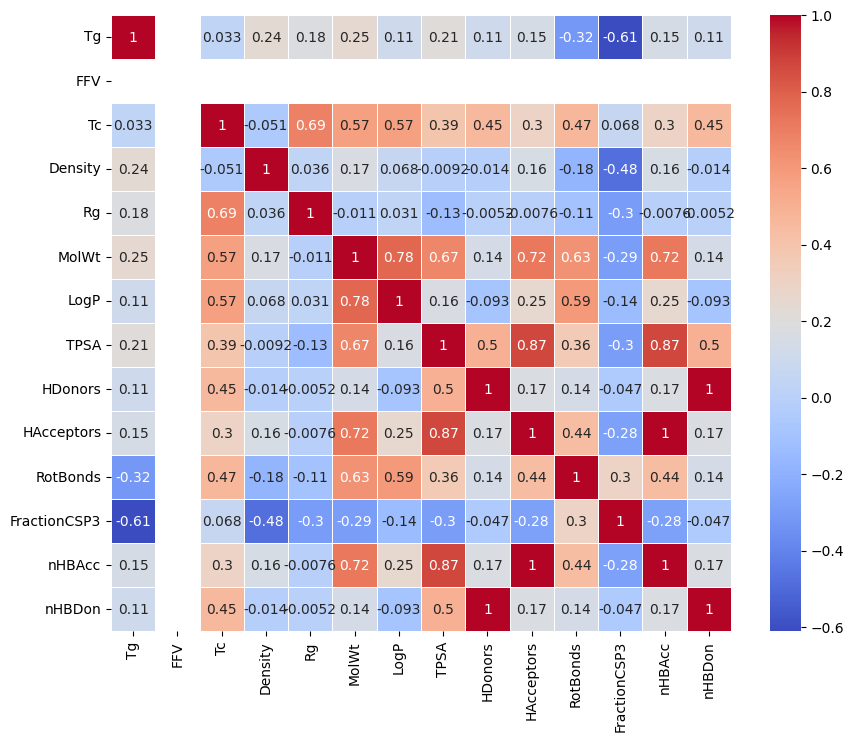

In [186]:
# Compute correlation matrix
corr_matrix = train_data.corr()

# Set figure size
plt.figure(figsize=(10,8))

#  Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Display the plot
plt.show()

In [162]:
# Input features (taking only values extracted from SMILES) and Target values
input_features = test_data.columns.to_list()
target_values = ['Tg']

# Drop rows with null target values
train_data = train_data.dropna(subset=target_values)

In [164]:
# ============================================================
#  Train test split and scaling
# ============================================================
# Input and target features
X = train_data[input_features]
y = train_data[target_values]

X_train, X_val, Y_train, Y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [168]:
# ============================================================
#  Linear Regression
# ============================================================

model_lr = LinearRegression()
model_lr.fit(X_train_scaled,Y_train)

Y_pred_lr = model_lr.predict(X_val_scaled)

# Compute performance metrics
mse_lr = mean_squared_error(Y_val, Y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(Y_val, Y_pred_lr)
r2_lr = r2_score(Y_val, Y_pred_lr)

# Print results
print(f"\nPerformance Evaluation of Linear regression model ")
print(f"RMSE: {rmse_lr :.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")



Performance Evaluation of Linear regression model 
RMSE: 75.86
Mean Absolute Error (MAE): 61.69
R² Score: 0.40


In [169]:
# ============================================================
#  Random Forest
# ============================================================
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled,Y_train)

Y_pred_rf = model_rf.predict(X_val_scaled)

# Compute performance metrics
mse_rf = mean_squared_error(Y_val, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(Y_val, Y_pred_rf)
r2_rf = r2_score(Y_val, Y_pred_rf)

# Print results
print(f"\nPerformance Evaluation of Random Forest model ")
print(f"RMSE: {rmse_rf :.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Performance Evaluation of Random Forest model 
RMSE: 74.11
Mean Absolute Error (MAE): 59.30
R² Score: 0.42


In [170]:
# Define Custom model
class Tg_Predictor_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output value
        )

    def forward(self, x):
        return self.model(x)

In [171]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define loss function
criterion = nn.MSELoss()

In [172]:
# Convert inputs and targets to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).view(-1, 1)



# Combine inputs and outputs into a dtaset
train_dataset = TensorDataset(X_train_tensor,Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

# Create DataLoader with batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create validation DataLoader with batching and without shuffling
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [173]:
# ============================================================
#  Train ANN Model
# ============================================================
# Lists to store losses
train_losses= []
val_losses = []
# Define model, optimizer and num_epochs
model_ann = Tg_Predictor_Model(input_size = X_train_scaled.shape[1]).to(device)
optimizer_ann = optim.Adam(model_ann.parameters(), lr=0.001)
best_loss_ann = float("inf")
num_epochs = 200

for epoch in range(num_epochs):
    model_ann.train()
    epoch_train_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer_ann.zero_grad()
        pred = model_ann(X_batch)
        loss = criterion(pred, Y_batch)
        loss.backward()
        optimizer_ann.step()
        epoch_train_loss += loss.item()

    avg_train = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model_ann.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            val_pred = model_ann(X_val)
            val_loss = criterion(val_pred, Y_val)
            epoch_val_loss += val_loss.item()

    avg_val = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val)

    if avg_val < best_loss_ann:
        best_loss_ann = avg_val
        torch.save(model_ann.state_dict(), f"/content/drive/MyDrive/Team-PINN/Research/Upoma/Practice/Polymer_Property_Prediction_Project/saved_models/Best_Tg_Predictor_Model.pth")

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_train:.6f}, Val Loss: {avg_val:.6f}")


Epoch 100, Train Loss: 3553.917568, Val Loss: 5480.683350
Epoch 200, Train Loss: 2847.216867, Val Loss: 6158.163330


In [174]:
# ============================================================
#  Validate ANN model
# ============================================================
# Load the saved model architecture
model_ann_best = Tg_Predictor_Model(input_size=X_train_scaled.shape[1])

# model to evaluation mode
model_ann_best.eval()

# Load the saved weights
model_ann_best.load_state_dict(torch.load("/content/drive/MyDrive/Team-PINN/Research/Upoma/Practice/Polymer_Property_Prediction_Project/saved_models/Best_Tg_Predictor_Model.pth"))


# Load the saved model architecture
with torch.no_grad():
    Y_pred_ann = model_ann_best(X_val_tensor)

# Convert predictions and targets to NumPy arrays
Y_pred_ann_np = Y_pred_ann.detach().cpu().numpy()
Y_test_np = Y_val_tensor.detach().cpu().numpy()

mse_ann = mean_squared_error(Y_test_np, Y_pred_ann_np)
rmse_ann = np.sqrt(mse_ann)
mae_ann = mean_absolute_error(Y_test_np, Y_pred_ann_np)
r2_ann = r2_score(Y_test_np, Y_pred_ann_np)

# Print results
print("Performance Evaluation of ANN Model")
print(f"RMSE: {rmse_ann:.2f}")
print(f"Mean Absolute Error (MAE): {mae_ann:.2f}")
print(f"R² Score: {r2_ann:.2f}")


Performance Evaluation of ANN Model
RMSE: 68.83
Mean Absolute Error (MAE): 53.50
R² Score: 0.50


In [177]:
'''
Monotonicity Loss
'''
# Define Physics loss function
def physics_loss(pred, X_batch):
    # Need to tune these weights later
    w_molwt = 2.0
    w_logp = 1.0
    w_tpsa = 1.0

    molwt = X_batch[:, 0]
    logp = X_batch[:, 1]
    tpsa = X_batch[:, 2]

    # Monotonicity penalties
    loss_molwt = torch.mean((pred.squeeze() - w_molwt * molwt) ** 2)   # Tg increase with MolWt
    loss_logp  = torch.mean((pred.squeeze() + w_logp * logp) ** 2)     # Tg decrease with LogP
    loss_tpsa  = torch.mean((pred.squeeze() - w_tpsa * tpsa) ** 2)     # Tg increase with TPSA

    # Combine them
    total_physics_loss = loss_molwt + loss_logp + loss_tpsa
    return total_physics_loss


In [178]:
# ============================================================
#  Train PINN model
# ============================================================
# Lists to store losses
train_losses_with_phys = []
val_losses_with_phys = []
# Intialization
model_pnn = Tg_Predictor_Model(input_size = X_train_scaled.shape[1]).to(device)
optimizer_pnn = optim.Adam(model_pnn.parameters(),lr=0.001)
best_loss_pnn = float("inf")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pnn , mode='min', factor=0.5, patience=20)


for epoch in range(num_epochs):
    model_pnn.train()
    epoch_train_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer_pnn.zero_grad()
        pred = model_pnn(X_batch)
        data_loss = criterion(pred, Y_batch)
        phy_loss = physics_loss(pred, X_batch)
        loss = data_loss + 0.05*phy_loss
        loss.backward()
        optimizer_pnn.step()
        epoch_train_loss += loss.item()

    avg_train = epoch_train_loss / len(train_loader)
    train_losses_with_phys.append(avg_train)

    # Validation
    model_pnn.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            val_pred = model_pnn(X_val)
            val_data_loss = criterion(val_pred, Y_val)
            val_phy_loss =  physics_loss(val_pred ,X_val)
            val_loss = val_data_loss + 0.05*val_phy_loss
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    val_losses_with_phys.append(avg_val_loss)

    if avg_val_loss < best_loss_pnn:
        best_loss_pnn = avg_val_loss
        torch.save(model_pnn.state_dict(), "Best_Tg_Predictor_Model_WithPhysics.pth")

    if (epoch + 1) % 100 == 0:
        print(f"[With Physics] Epoch {epoch+1}, Train Loss: {avg_train:.2f}, Val Loss: {avg_val_loss:.2f}")



[With Physics] Epoch 100, Train Loss: 6312.70, Val Loss: 6393.18
[With Physics] Epoch 200, Train Loss: 6410.81, Val Loss: 6542.03


In [179]:
# ============================================================
#  Validate PINN model
# ============================================================
# Load the saved model architecture
model_pnn_best = Tg_Predictor_Model(input_size = X_train_scaled.shape[1])


# model to evaluation mode
model_pnn_best.eval()


# Load the saved weights
model_pnn_best.load_state_dict(torch.load("Best_Tg_Predictor_Model_WithPhysics.pth"))

# Disable gradient computation during inference
with torch.no_grad():
    Y_pred_pnn = model_pnn_best(X_val_tensor)

# Convert predictions and targets to NumPy arrays
Y_pred_pnn_np = Y_pred_pnn.detach().cpu().numpy()
Y_test_np = Y_val_tensor.detach().cpu().numpy()


mse_pnn = mean_squared_error(Y_test_np, Y_pred_pnn_np)
rmse_pnn = np.sqrt(mse_pnn)
mae_pnn = mean_absolute_error(Y_test_np, Y_pred_pnn_np)
r2_pnn = r2_score(Y_test_np, Y_pred_pnn_np)

# Print results
print("Performance Evaluation of PINN Model")
print(f"RMSE: {rmse_pnn:.2f}")
print(f"Mean Absolute Error (MAE): {mae_pnn:.2f}")
print(f"R² Score: {r2_pnn:.2f}")


Performance Evaluation of PINN Model
RMSE: 66.33
Mean Absolute Error (MAE): 52.09
R² Score: 0.54
